In [1]:
code_path = '/your/path/here'
positions_dir = '/your/path/here'
weights_path = '/your/path/here'
image_path = '/your/path/here'

In [2]:
import sys
sys.path.append(code_path)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.positions import NetworkPositions
from src.model import load_model_from_checkpoint, LAYERS
from src.data import load_image, create_dataloader
from src.features import FeatureExtractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# load positions from each model layer
network_positions = NetworkPositions.load_from_dir(positions_dir)

In [5]:
# load model from checkpoint and send to appropriate device
model = load_model_from_checkpoint(weights_path)
model = model.to(DEVICE)

In [6]:
# create a dataloader to serve the single image we're pointing to
dataloader = create_dataloader(load_image(image_path))

In [7]:
# extract features for all layers, also storing the images and labels
extractor = FeatureExtractor(dataloader, n_batches=1, verbose=True)
features, inputs, labels = extractor.extract_features(
    model, LAYERS, return_inputs_and_labels=True
)

batch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


(-0.5, 223.5, 223.5, -0.5)

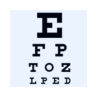

In [8]:
# view the input image
# remove batch dim, and move channels to the end
raw = inputs[0].squeeze().transpose(1, 2, 0)

# normalize image to the range [0, 1]
normed = (raw - np.min(raw)) / np.ptp(raw)

# plot
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(normed)
ax.axis("off")

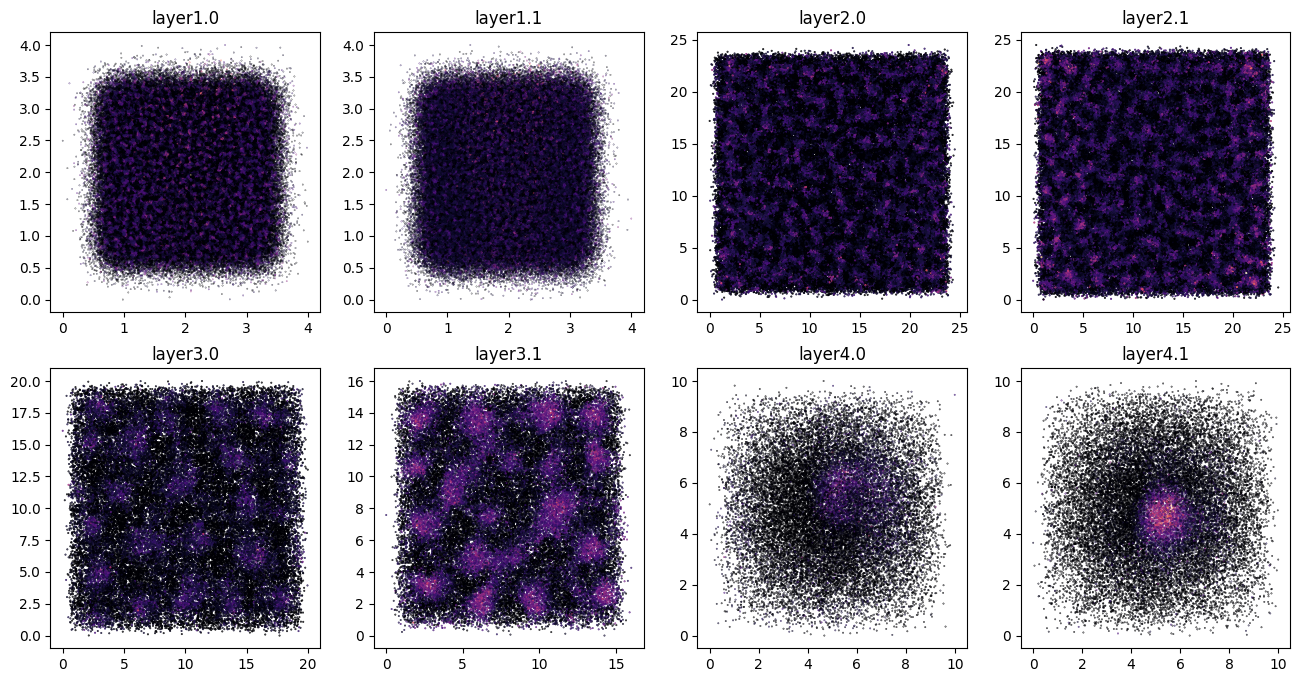

In [9]:
# show response magnitude in each layer
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(16, 8)
)

for ax, layer in zip(axes.ravel(), LAYERS):
    # coordinates is an N x 2 matrix of unit positions, in mm
    coordinates = network_positions.layer_positions[layer].coordinates
    
    # responses is an N-dimensional response vector from each layer
    responses = features[layer]
    
    # plot points, scaling by total size of the tissue in each layer
    extent = np.ptp(coordinates)
    ax.scatter(*coordinates.T, c=responses, cmap='magma', s=extent / 100)
    ax.set_title(layer)